# Group Decision Experiments

This notebook runs group decision experiments inspired by Alex Lamb's piece [Why The World Has Gone Crazy](https://thetinkerpoint.com/2019/02/11/why-the-world-has-gone-crazy/). 

I wrote some about this article [here](https://nicktorba.com/brain/why-the-world-has-gone-crazy). I found these simulations really interesting and wanted to expand on the code and create more (that Alex did release [on github](https://github.com/alexlamb/groupdecision))

More of Alex's work: 
* https://observablehq.com/@alexlamb/iterated-prisoners-dilemma
* https://observablehq.com/@alexlamb/prisoners-dilemma-with-kin-cues
* https://observablehq.com/@alexlamb/prisoners-dilemma-with-wealth-cues
* https://www.youtube.com/watch?v=oarsWELcJR8

I may end up adding Alex-inpsired simluations to this library. 

These simulations are a simple starting point that shows a interesting effects that can help us understand exactly how much influence powerful individuals have on our society. 



In [1]:
import random 
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from network_simulations.group_decision.builders import scale_free_with_opinions, random_network_with_opinions
from network_simulations.group_decision.group_decision import run, random_update, get_opinions, is_converged, add_influence


In [2]:
NUM_EXPERIMENTS = 200
SIM_STEPS=1000
NUM_NODES=20
MIN_NEIGHBORS=4
OPINION_A_COUNT=5 # opinion a is at an advantaged when setting bias=True
OPINION_B_COUNT=5
NO_OPINION=0 
OPINION_A=1
OPINION_B=2
DECIDED=0.7
UNDECIDED=0.3

## Running a Single Group Decision Experiment
This is how you can simulate networked group decision making a single time. 
In this examplle, I use an unbiased scale free network. 

We plot the change in decisions up to convergence (all nodes in the graph agreeing) or up to `SIM_STEPS` steps. 

You can run this sim a few times, with different settings, to get a handle on how the outcomes can differ (especially for unbiased graphs). 


In [3]:
initial_network = scale_free_with_opinions(
    num_nodes=NUM_NODES,
    min_neighbors=MIN_NEIGHBORS,
    opinion_a_count=OPINION_A_COUNT,
    opinion_b_count=OPINION_B_COUNT,
    no_opinion=NO_OPINION,
    opinion_a=OPINION_A,
    opinion_b=OPINION_B,
    decided=DECIDED,
    undecided=UNDECIDED,
    bias=False
)

states = run(initial_network, random_update, get_opinions, is_converged, SIM_STEPS)

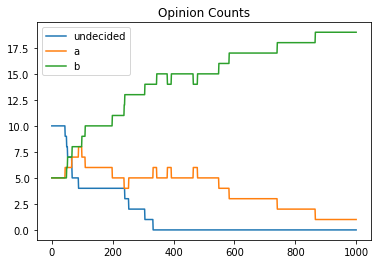

In [4]:
def plot_single_experiment(states):
    df = pd.DataFrame(states, columns=["undecided", "a", "b"])
    df.plot(y=["undecided", "a", "b"], title="Opinion Counts")
    plt.show()
    
plot_single_experiment(states)

# Results in Aggregate
It's hard to get a good idea bigger picture effects of the above settings from a single run of the simulation.
Instead, we can look at the aggregate numbers of many experiments to see how different networks are effected by bias. 

First, we look at Scale Free Networks, then we compare those Results to Random Networks

## Scale Free Networks - Biased vs. Random
Going to run NUM_EXPERIMENTS biased experiments vs NUM_EXPERIMENTS random experiments 

Interested in:
    * average/median length to convergence
    * distribution of winners
    

In [5]:
## Utility functions for analysis 

import statistics as stats 

def mean_length(experiment_states):
    return stats.mean([len(i) for i in experiment_states])

def median_length(experiment_states):
    return stats.median([len(i) for i in experiment_states])

def decision_results(experiment_states):
    results = [0,0,0]
    final_states = [i[-1] for i in experiment_states]
    for i_state in final_states:
        max_index = i_state.index(max(i_state))
        results[max_index] += 1
    return results

def plot_decision_results(results, title):
    opinions = ["undecided", "a", "b"]
    fig = plt.figure(figsize = (10, 5))
    # creating the bar plot
    plt.bar(opinions, results)#, color ='maroon', width = 0.4)

    plt.xlabel("Opinions")
    plt.ylabel("Num Experiments in favor of")
    plt.title(title)
    plt.show()

### Scale Free - Random Opinion Initialization

mean lenght to converge:  663.93
median_length to converge:  659.5
Undecided: 1,Opinion a: 99,Opinion b: 100,


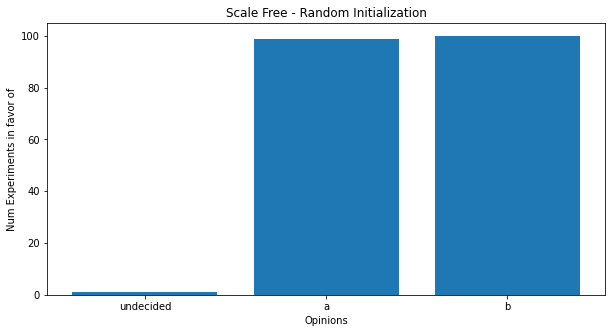

In [6]:
# Random 
experiment_states = []

for i in range(NUM_EXPERIMENTS):
    scale_free_random_network = scale_free_with_opinions(
        num_nodes=NUM_NODES,
        min_neighbors=MIN_NEIGHBORS,
        opinion_a_count=OPINION_A_COUNT,
        opinion_b_count=OPINION_B_COUNT,
        no_opinion=NO_OPINION,
        opinion_a=OPINION_A,
        opinion_b=OPINION_B,
        decided=DECIDED,
        undecided=UNDECIDED,
        bias=False # This produces random network
    )
    states = run(
        network=scale_free_random_network, 
        update_network=random_update, 
        extract_state=get_opinions, 
        converged=is_converged, 
        num_steps=SIM_STEPS
    )
    experiment_states.append(states)

print("mean lenght to converge: ", mean_length(experiment_states))
print("median_length to converge: ", median_length(experiment_states))

results = decision_results(experiment_states)
print(f"Undecided: {results[0]},"
      f"Opinion a: {results[1]},"
      f"Opinion b: {results[2]},"
     )

plot_decision_results(results, "Scale Free - Random Initialization")

### Scale Free - Biased Opinion Initialization

mean length to converge:  539.69
median length to converge:  425.0
Undecided:0, Opinion a = 163, Opinion b = 37, 


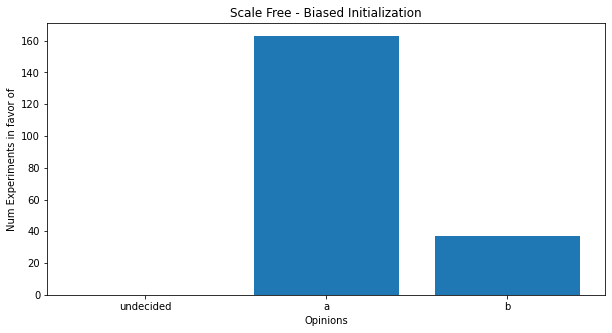

In [7]:
experiment_states = []

for i in range(NUM_EXPERIMENTS):
    scale_free_biased_network = scale_free_with_opinions(
        NUM_NODES,
        MIN_NEIGHBORS,
        OPINION_A_COUNT,
        OPINION_B_COUNT,
        NO_OPINION,
        OPINION_A,
        OPINION_B,
        DECIDED,
        UNDECIDED,
        bias=True # This produces biased network - the most connected nodes get opinion_a, least connected get opinion_b
    )
    states = run(scale_free_biased_network, random_update, get_opinions, is_converged, SIM_STEPS)
    experiment_states.append(states)

print("mean length to converge: ", mean_length(experiment_states))
print("median length to converge: ", median_length(experiment_states))

results = decision_results(experiment_states)
print(f"Undecided:{results[0]}, "
      f"Opinion a = {results[1]}, "
      f"Opinion b = {results[2]}, "
     )
plot_decision_results(decision_results(experiment_states), "Scale Free - Biased Initialization")

### Random Networks - Scale Free and Random 

mean length to converge:  925.015
median length to converge:  1001.0
Undecided:1,Opinion a = 102,Opinion b = 97,


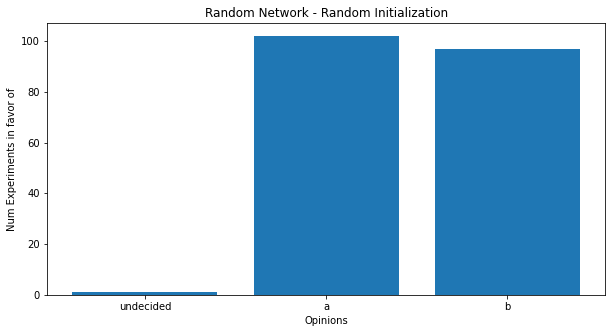

In [8]:
# Random 
experiment_states = []

for i in range(NUM_EXPERIMENTS):
    random_random_network = random_network_with_opinions(
        NUM_NODES,
        MIN_NEIGHBORS,
        OPINION_A_COUNT,
        OPINION_B_COUNT,
        NO_OPINION,
        OPINION_A,
        OPINION_B,
        DECIDED,
        UNDECIDED,
        bias=False # This produces random network
    )
    states = run(random_random_network, random_update, get_opinions, is_converged, SIM_STEPS)
    experiment_states.append(states)

print("mean length to converge: ", mean_length(experiment_states))
print("median length to converge: ", median_length(experiment_states))

results = decision_results(experiment_states)
print(f"Undecided:{results[0]},"
      f"Opinion a = {results[1]},"
      f"Opinion b = {results[2]},"
     )

plot_decision_results(results, "Random Network - Random Initialization")

mean length to converge:  906.79
median length to converge:  1001.0
Undecided:1, Opinion a = 139, Opinion b = 60, 


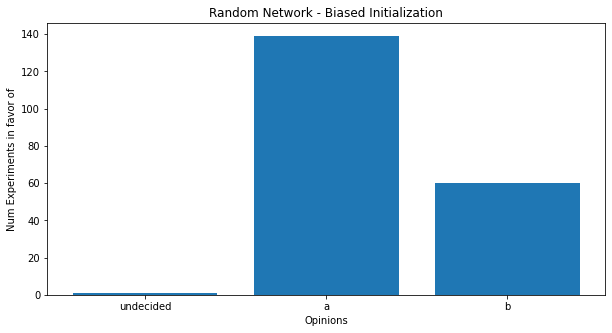

In [9]:
## Biased 
experiment_states = []
for i in range(NUM_EXPERIMENTS):
    random_biased_network = random_network_with_opinions(
        NUM_NODES,
        MIN_NEIGHBORS,
        OPINION_A_COUNT,
        OPINION_B_COUNT,
        NO_OPINION,
        OPINION_A,
        OPINION_B,
        DECIDED,
        UNDECIDED,
        bias=True # This produces random network
    )
    states = run(random_biased_network, random_update, get_opinions, is_converged, SIM_STEPS)
    experiment_states.append(states)

print("mean length to converge: ", mean_length(experiment_states))
print("median length to converge: ", median_length(experiment_states))

results = decision_results(experiment_states)
print(f"Undecided:{results[0]}, "
      f"Opinion a = {results[1]}, "
      f"Opinion b = {results[2]}, "
     )
plot_decision_results(decision_results(experiment_states), "Random Network - Biased Initialization")

### Next Steps:

#### Grid Search
Grid Search over many different values for the constants that I have... I'm curious in how all of the variables effect aggregate outcomes: 
* min_neighbors
* decived vs undecided
* size of network, At what deficit can a biased network overcome? 
    * does min_neighbors have a strong effect here? 
    * hypothesis: the higher the proportion of undecided there is an in a population, the more susceptible the graph will be to powerful nodes 

#### Grab single plots from aggregate
I wanna be able to quickly graph results from a single experiment based on results from aggregate.
Example: There was only one run that ended opinion_b, plot that one...

#### Early Convergence
In graphs of single experiments, there is usually a pretty clear splitting point at which you can tell where the graph will ultimately converge. How could I detect that earlier so I can not wait for the full number of iterations for an experiment to complete? 



## Open Questions
1. What is the node distribution of random networks? 
    1. should we look at the node distribution of random networks? 
    
    
2. Can the node distribution change throughout simulation? What effect would that investigate? 

### Notes 

We want to build environments that give opinions equal chance to succeed, but one of them will still succeed. We do not have ultimate control, but we can try design environments that are unbiased so that we end up with more confidence in the opinions that are selected... 